In [1]:
from codes.python import load_database,ECG_denoising
from codes.python import QRS_detector
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
import operator
from numpy import array
import sys
import csv
import os
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing, plot
from codes.python import heartbeat_segmentation as shs
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import pywt
from biosppy.signals import ecg
from sklearn import metrics
#import waipy
import operator
from codes.python import ecg_waveform_extractor as waveform
import time as system_time
from scipy import stats

In [2]:
def average(numbers):
    return float(sum(numbers)) / len(numbers)
def peak_properties_extractor(sig,start_point=None,end_point=None,height=None, distance=None, width = None, plateau_size=None):
    sig = sig[start_point:end_point]
    peaks,properties  = np.asarray(signal.find_peaks(sig, height=height, distance=distance,width=width,plateau_size=plateau_size))
    return peaks,properties

def point_transform_to_origin(por,point):
    point_from_origin = por + point 
    return point_from_origin

def origin_to_new_point(por,point_from_origin):
    point = point_from_origin - por
    return point

def peak_duration(time,right_edge, left_edge,point_from_origin):
    right_edge = point_transform_to_origin(point_from_origin,right_edge)
    left_edge = point_transform_to_origin(point_from_origin,left_edge)
    
    return float(time[right_edge]-time[left_edge])

def sub_signal_interval(time, start_point, end_point,point_from_origin):
    start_point = point_transform_to_origin(point_from_origin,start_point)
    end_point = point_transform_to_origin(point_from_origin,end_point)
    
    return float(time[end_point]-time[start_point])

def peak_height(signal, peak, prominence,point_from_origin):
    peak = point_transform_to_origin(point_from_origin,peak)
    height = signal[peak]-(signal[peak] - prominence)
    return height

def area_under_curve(signal,time,samples,point_from_origin):
    samples = [point_transform_to_origin(i,point_from_origin) for i in samples]
    time = np.asarray(time)
    amplitude = np.asarray(signal)
    area = metrics.auc(time[samples],amplitude[samples])
    return area

def amplitude(signal,samples,point_from_origin):
    samples = [point_transform_to_origin(i,point_from_origin) for i in samples]
    signal = np.asarray(signal)
    amplitudes = signal[samples]
    return amplitudes

In [3]:
mit100 = load_database.load_patient_record("mitdb","100")
mit100.set_segmented_beats_r_pos(winL=100,winR=200)
filtere_MLII = mit100.filtered_MLII

C:\Users\chont\OneDrive\Documents\GitHub\ECGdataAnalysis/database/mitdb/100
C:\Users\chont\OneDrive\Documents\GitHub\ECGdataAnalysis/database/mitdb/csv/100.csv
C:\Users\chont\OneDrive\Documents\GitHub\ECGdataAnalysis/database/mitdb/csv/100.txt
C:\Users\chont\OneDrive\Documents\GitHub\ECGdataAnalysis/database/mitdb/p_t_wave/100pt.csv
Start segmenting records: 100
Filtered MLII records from : 100
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 100 completes.


In [4]:
mit100.set_Q_S_points_MLII()

Processing file: 100
Patient file:  100 begins
Done proecessing: 100


In [5]:
mit100.Q_points

[359,
 653,
 936,
 1221,
 1505,
 1799,
 2034,
 2392,
 2696,
 2988,
 3273,
 3550,
 3852,
 4160,
 4456,
 4754,
 5050,
 5336,
 5622,
 5909,
 6204,
 6517,
 6813,
 7096,
 7379,
 7660,
 7943,
 8235,
 8529,
 8827,
 9131,
 9421,
 9700,
 9988,
 10272,
 10580,
 10884,
 11182,
 11470,
 11770,
 12056,
 12339,
 12635,
 12939,
 13255,
 13552,
 13832,
 14121,
 14413,
 14701,
 15001,
 15300,
 15597,
 15890,
 16172,
 16454,
 16745,
 17048,
 17348,
 17645,
 17937,
 18216,
 18503,
 18784,
 19071,
 19378,
 19682,
 19979,
 20262,
 20544,
 20828,
 21121,
 21413,
 21719,
 22019,
 22311,
 22593,
 22871,
 23154,
 23443,
 23746,
 24043,
 24336,
 24616,
 24902,
 25188,
 25475,
 25769,
 26077,
 26377,
 26661,
 26942,
 27227,
 27526,
 27822,
 28121,
 28421,
 28717,
 29004,
 29284,
 29569,
 29862,
 30172,
 30477,
 30770,
 31055,
 31339,
 31625,
 31917,
 32213,
 32518,
 32826,
 33116,
 33394,
 33680,
 33969,
 34264,
 34565,
 34860,
 35158,
 35445,
 35726,
 36006,
 36298,
 36595,
 36906,
 37205,
 37490,
 37773,
 3806

In [6]:
mit100.S_points

array([   380,    671,    955, ..., 649240, 649492, 649742])

In [7]:
index = list(range(0,10000))


In [8]:
r_peaks = shs.r_peak_detector(signal=filtere_MLII,annotations=mit100.annotations,indexes=index,  winL=180, winR=180,size_RR_max=5)
r_peaks = np.asarray(r_peaks)

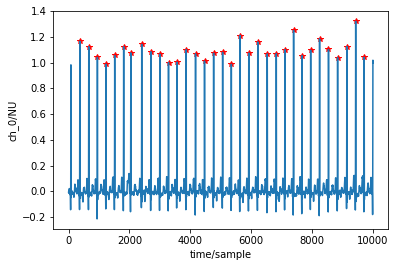

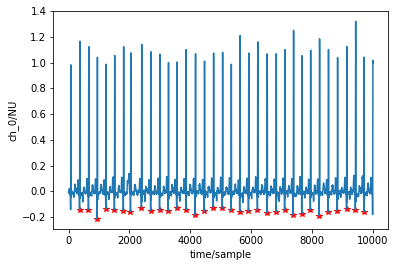

In [19]:
wfdb.plot_items(signal=filtere_MLII[index], ann_samp=[r_peaks])
time = np.asarray(mit100.time)
time = time[index]

q_points = shs.find_Q_point(signal=filtere_MLII[index],time=time, R_peaks=r_peaks, time_limit = 0.01,limit=50)

wfdb.plot_items(signal=filtere_MLII[index], ann_samp=[q_points])



In [80]:
start_time = system_time.time()
properties = r_peak_properties_extractor(mit100,to_area=False)
end_time = system_time.time()
print(end_time-start_time)

Patient file:  100 begins


C:\Users\nimch681\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Patient file:  100 processing end
2.3251736164093018


In [11]:
properties

{'peaks': [370,
  663,
  947,
  1231,
  1515,
  1810,
  2045,
  2403,
  2706,
  2998,
  3283,
  3560,
  3863,
  4171,
  4466,
  4765,
  5061,
  5347,
  5634,
  5919,
  6215,
  6527,
  6824,
  7106,
  7392,
  7670,
  7953,
  8246,
  8539,
  8838,
  9142,
  9432,
  9710,
  9998,
  10282,
  10591,
  10895,
  11192,
  11481,
  11781,
  12066,
  12350,
  12645,
  12950,
  13267,
  13562,
  13842,
  14131,
  14423,
  14711,
  15011,
  15310,
  15607,
  15900,
  16183,
  16465,
  16755,
  17058,
  17358,
  17657,
  17947,
  18227,
  18514,
  18796,
  19081,
  19388,
  19693,
  19990,
  20272,
  20554,
  20838,
  21132,
  21424,
  21729,
  22030,
  22321,
  22603,
  22881,
  23164,
  23454,
  23757,
  24053,
  24346,
  24626,
  24914,
  25198,
  25485,
  25780,
  26089,
  26387,
  26671,
  26952,
  27238,
  27536,
  27833,
  28133,
  28431,
  28727,
  29015,
  29294,
  29581,
  29873,
  30182,
  30487,
  30780,
  31065,
  31349,
  31636,
  31928,
  32224,
  32530,
  32837,
  33127,
  33404,
  

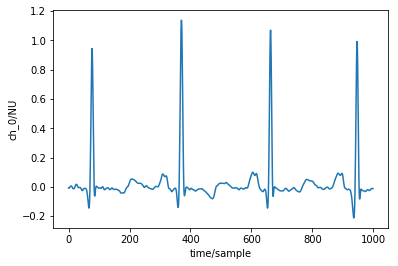

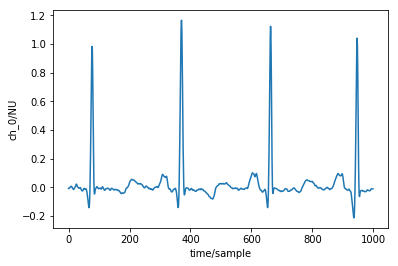

In [16]:
sav_sig = savgol_filter(filtere_MLII,17,4)
wfdb.plot_items(signal=sav_sig[0:1000])
wfdb.plot_items(signal=filtere_MLII[0:1000])




In [17]:
z_score = stats.zscore(filtere_MLII)

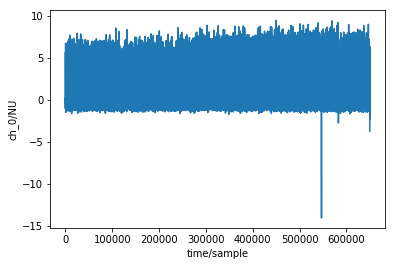

In [18]:
wfdb.plot_items(signal=z_score)


In [79]:
def r_peak_properties_extractor(patient,sample_from_R=[0,11], to_area=True,to_savol=True, Order=4,window_len=17, left_limit=50,right_limit=50, distance=20, width=[0,100],plateau_size=[0,100]):
    
    peaks = []
    heights = []
    durations = []
    areas = []
    onset = []
    offset = []
    amps = []
    promi = []
    sigs = []
    start_points = []
    end_points = []
    time = patient.time
    print("Patient file: ",patient.filename, "begins")
    
    if(patient.filtered_MLII == []):
        print("Please filter the signal")
        return
    if(patient.segmented_R_pos == []):
        print("please segment the signal to find R peak")
        return
    
    for r in patient.segmented_R_pos:
        start_point = r-left_limit
        end_point = r+right_limit
        MLII = []
        sig = []
        if(patient.filtered_MLII[r] >= 0):
            MLII = patient.filtered_MLII
            sig = MLII[start_point:end_point]
            height = min(sig)   
            peak,properties = peak_properties_extractor(sig,height=height, distance=distance, width = width, plateau_size=plateau_size)
        else:
            MLII = -patient.filtered_MLII
            sig = MLII[start_point:end_point]
            height = min(sig)   
            peak,properties = peak_properties_extractor(sig,height=height, distance=distance, width = width, plateau_size=plateau_size)
        
        sigs.append(sig)
        if(to_savol == True):
            savgol_signal = savgol_filter(sig,window_len,Order)
        else:
            savgol_signal = sig
        start_points.append(start_point)
        end_points.append(end_point)
        

        
        height = min(savgol_signal)   
        peak_savol,properties_savol = peak_properties_extractor(savgol_signal,height=height, distance=distance, width=width, plateau_size=plateau_size)
        old_sig = savgol_signal
        savgol_signal = savgol_signal[peak_savol]
       
        value = max(savgol_signal)
        index = np.where(savgol_signal==value)
        
        index = int(index[0])
    
        peak_savol = peak_savol[index]
        peak_savol = point_transform_to_origin(start_point,peak_savol)
        
        left_ips = np.asarray(properties_savol["left_ips"])
        right_ips = np.asarray(properties_savol["right_ips"])
        left_ips = [int(i) for i in left_ips]
        right_ips = [int(i) for i in right_ips]
    
        left_edge = left_ips[index]
        right_edge = right_ips[index]
        duration = round(peak_duration(time=patient.time,right_edge=right_edge, left_edge=left_edge,point_from_origin=start_point),3)
        prominences = np.asarray(properties_savol["prominences"])
        prominence = prominences[index]
        height = round(peak_height(MLII, peak_savol, prominence,0),3)
        peaks.append(peak_savol)
        durations.append(duration)
        promi.append(prominence)
        amp = amplitude(patient.filtered_MLII,list(range(sample_from_R[0],sample_from_R[1])),start_point)
        heights.append(height)
        if(to_area==True):
            samples = list(range(left_edge,right_edge+1))
            area = round(area_under_curve(patient.filtered_MLII,time,samples,start_point),3)
            areas.append(area)
        amps.append(amp)
        offset.append(right_edge+5)
        onset.append(left_edge+5)
        
    properties = {
        "start_points" : start_points,
        "end_points" : end_points,
        "samples" : sigs,
        "peaks" : peaks,
        "durations" : durations,
        "prominences" : promi,
        "height" : heights,
        "amplitudes" : amps,
        "areas" : areas,
        "onset" : onset,
        "offset" : offset
        }
    print("Patient file: ",patient.filename, "processing end")
    return properties    
    

In [ ]:
def Q_points_properties_extractor(patient,sample_from_R=[0,11], to_area=True,to_savol=True, Order=4,window_len=17, left_limit=50,right_limit=50, distance=20, width=[0,100],plateau_size=[0,100]):
    
    peaks = []
    heights = []
    durations = []
    areas = []
    onset = []
    offset = []
    amps = []
    promi = []
    sigs = []
    start_points = []
    end_points = []
    time = patient.time
    print("Patient file: ",patient.filename, "begins")
    
    if(patient.filtered_MLII == []):
        print("Please filter the signal")
        return
    if(patient.segmented_R_pos == []):
        print("please segment the signal to find R peak")
        return
    
    for r in patient.segmented_R_pos:
        r_peak = r
        start_point = r-left_limit
        end_point = r+right_limit
        MLII = []
        sig = []
        if(patient.filtered_MLII[r] >= 0):
            MLII = patient.filtered_MLII
            sig = MLII[start_point:end_point]
            height = min(sig)   
            peak,properties = peak_properties_extractor(sig,height=height, distance=distance, width = width, plateau_size=plateau_size)
        else:
            MLII = -patient.filtered_MLII
            sig = MLII[start_point:end_point]
            height = min(sig)   
            peak,properties = peak_properties_extractor(sig,height=height, distance=distance, width = width, plateau_size=plateau_size)
        
        sigs.append(sig)
        if(to_savol == True):
            savgol_signal = savgol_filter(sig,window_len,Order)
        else:
            savgol_signal = sig
        start_points.append(start_point)
        end_points.append(end_point)
        

        
        height = min(savgol_signal)   
        peak_savol,properties_savol = peak_properties_extractor(savgol_signal,height=height, distance=distance, width=width, plateau_size=plateau_size)
        old_sig = savgol_signal
        savgol_signal = savgol_signal[peak_savol]
       
        value = max(savgol_signal)
        index = np.where(savgol_signal==value)
        
        index = int(index[0])
    
        peak_savol = peak_savol[index]
        peak_savol = point_transform_to_origin(start_point,peak_savol)
        
        left_ips = np.asarray(properties_savol["left_ips"])
        right_ips = np.asarray(properties_savol["right_ips"])
        left_ips = [int(i) for i in left_ips]
        right_ips = [int(i) for i in right_ips]
    
        left_edge = left_ips[index]
        right_edge = right_ips[index]
        duration = round(peak_duration(time=patient.time,right_edge=right_edge, left_edge=left_edge,point_from_origin=start_point),3)
        prominences = np.asarray(properties_savol["prominences"])
        prominence = prominences[index]
        height = round(peak_height(MLII, peak_savol, prominence,0),3)
        peaks.append(peak_savol)
        durations.append(duration)
        promi.append(prominence)
        amp = amplitude(patient.filtered_MLII,list(range(sample_from_R[0],sample_from_R[1])),start_point)
        heights.append(height)
        if(to_area==True):
            samples = list(range(left_edge,right_edge+1))
            area = round(area_under_curve(patient.filtered_MLII,time,samples,start_point),3)
            areas.append(area)
        amps.append(amp)
        offset.append(right_edge+5)
        onset.append(left_edge+5)
        
    properties = {
        "start_points" : start_points,
        "end_points" : end_points,
        "samples" : sigs,
        "peaks" : peaks,
        "durations" : durations,
        "prominences" : promi,
        "height" : heights,
        "amplitudes" : amps,
        "areas" : areas,
        "onset" : onset,
        "offset" : offset
        }
    print("Patient file: ",patient.filename, "processing end")
    return properties    
    

In [96]:
peak = properties["peaks"][0]
samples = properties["samples"][0]
start = properties["start_points"][0]
peak = origin_to_new_point(start,peak)
peaks = np.zeros(shape=(1),dtype=int)
peaks[0] = peak
for key in properties:
    print("the key name is", key)

the key name is start_points
the key name is end_points
the key name is samples
the key name is peaks
the key name is durations
the key name is prominences
the key name is height
the key name is amplitudes
the key name is areas
the key name is onset
the key name is offset


49

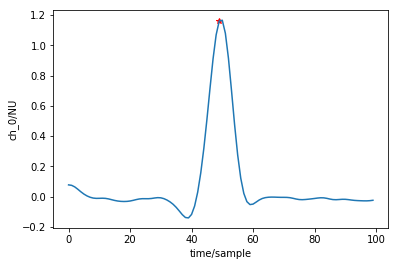

In [97]:
wfdb.plot_items(signal=samples,ann_samp=[peaks])


In [68]:
type(peaks)
peaks

array([0.])